In [1]:
import pandas as pd
df = pd.read_csv("df_clean.csv")
df.head()



,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEUIWN(kBtu/sf)
0,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,Hotel,Hotel,Unknown,31733.045429,Unknown,12311.108329,84.300003
1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,"Hotel, Parking, Restaurant",Hotel,Parking,15064.000000,Restaurant,4622.000000,97.900002
2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,Hotel,Hotel,Unknown,31733.045429,Unknown,12311.108329,97.699997
3,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,Hotel,Hotel,Unknown,31733.045429,Unknown,12311.108329,113.300003
4,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,"Hotel, Parking, Swimming Pool",Hotel,Parking,68009.000000,Swimming Pool,0.000000,118.699997


### Features prévues

1. **Âge du bâtiment**  
   **Formule :** `buildingage = 2025 - YearBuilt`  
   **Pourquoi :** l’année brute est peu parlante. L’âge capture mieux la vétusté (isolation, systèmes, rénovations probables).  
   **Info :** les bâtiments anciens ont souvent un **SiteEUI** plus élevé.

2. **Nombre d’usages du bâtiment**  
   **Formule :** `UsageCount = nombre d’usages dans ListOfAllPropertyUseTypes`  
   **Pourquoi :** un bâtiment multi-usage (ex : commerce + bureau) a des profils énergétiques plus complexes qu’un bâtiment mono-usage.  
   **Info :** les combinaisons d’usages modifient les comportements de consommation.

3. **Ratio parking / surface totale**  
   **Formule :** `ParkingRatio = PropertyGFAParking / PropertyGFATotal`  
   **Pourquoi :** le parking est peu chauffé/climatisé. S’il représente une grosse part de la surface, il influence la consommation rapportée au m².  
   **Info :** deux bâtiments similaires peuvent paraître très différents à cause d’un parking dominant.

4. **Densité d’étages (compacité verticale)**  
   **Formule :** `FloorDensity = NumberofFloors / PropertyGFATotal`  
   **Pourquoi :** à surface équivalente, un bâtiment plus vertical (compact) n’a pas les mêmes déperditions qu’un bâtiment étalé.  
   **Info :** cette feature capture la forme du bâtiment (vertical vs horizontal), souvent liée à l’efficacité énergétique.

5. **Distance au centre-ville**  
   **Formule :** `DistanceToDowntown_km = Haversine(Latitude, Longitude, lat_centre, lon_centre)`  
   **Pourquoi :** proxy simple de l’environnement urbain (densité, typologie, âge moyen du bâti, usages).  
   **Info :** les zones centrales et périphériques peuvent présenter des profils énergétiques différents, même à caractéristiques bâtimentaires proches.


1. Age du batiment

In [2]:
df["buildingage"] = 2025 - df["YearBuilt"]


In [3]:
df.columns


Index(['BuildingType', 'PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'SiteEUIWN(kBtu/sf)', 'buildingage'],
      dtype='object')

2. Nombre d’usages du bâtiment

In [4]:
def count_usages(value):
    if pd.isna(value):
        return 0
    else:
        return len(value.split(','))

df["UsageCount"] = df["ListOfAllPropertyUseTypes"].apply(count_usages)

df["UsageCount"].value_counts()


UsageCount
1     687
2     481
3     197
4      79
5      39
6      18
7       4
9       2
11      1
13      1
8       1
Name: count, dtype: int64

3. Ratio parking / surface totale


In [5]:
df["ParkingRatio"] = df["PropertyGFAParking"] / df["PropertyGFATotal"]


df["ParkingRatio"].describe()


count    1510.000000
mean        0.064795
std         0.144019
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.895023
Name: ParkingRatio, dtype: float64

4. Densité d'étage


In [6]:
df["FloorDensity"] = df["NumberofFloors"] / df["PropertyGFATotal"]

df["FloorDensity"].describe()


count    1510.000000
mean        0.000059
std         0.000121
min         0.000000
25%         0.000027
50%         0.000045
75%         0.000077
max         0.004511
Name: FloorDensity, dtype: float64

5. distance du centre ville

In [7]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # rayon de la Terre en km

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

df["DistanceToDowntown_km"] = haversine(
    df["Latitude"],
    df["Longitude"],
    47.6062,
    -122.3321
)

df["DistanceToDowntown_km"].describe()


count    1510.000000
mean        4.391950
std         3.507290
min         0.034028
25%         1.365019
50%         3.384191
75%         6.601198
max        14.242219
Name: DistanceToDowntown_km, dtype: float64

In [8]:
features_to_drop = ["YearBuilt"]
df_model = df.drop(columns=features_to_drop)

df_model.to_csv("df_features.csv", index=False)


In [9]:
df.head()


,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEUIWN(kBtu/sf),buildingage,UsageCount,ParkingRatio,FloorDensity,DistanceToDowntown_km
0,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,...,Unknown,31733.045429,Unknown,12311.108329,84.300003,98,1,0.000000,0.000136,0.800050
1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,...,Parking,15064.000000,Restaurant,4622.000000,97.900002,29,3,0.145453,0.000106,0.787077
2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,...,Unknown,31733.045429,Unknown,12311.108329,97.699997,56,1,0.205748,0.000043,0.970109
3,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,...,Unknown,31733.045429,Unknown,12311.108329,113.300003,99,1,0.000000,0.000163,0.944139
4,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,...,Parking,68009.000000,Swimming Pool,0.000000,118.699997,45,3,0.353115,0.000103,1.048092


In [10]:
import os

os.listdir()


['bentofile.yaml',
 '__pycache__',
 '.git',
 'Feature NB.ipynb',
 'Notebook P6.ipynb',
 'service.py',
 'Data',
 '.venv',
 'TrainTest.ipynb',
 '.ipynb_checkpoints',
 '.gitignore',
 'df_features.csv',
 'df_clean.csv']

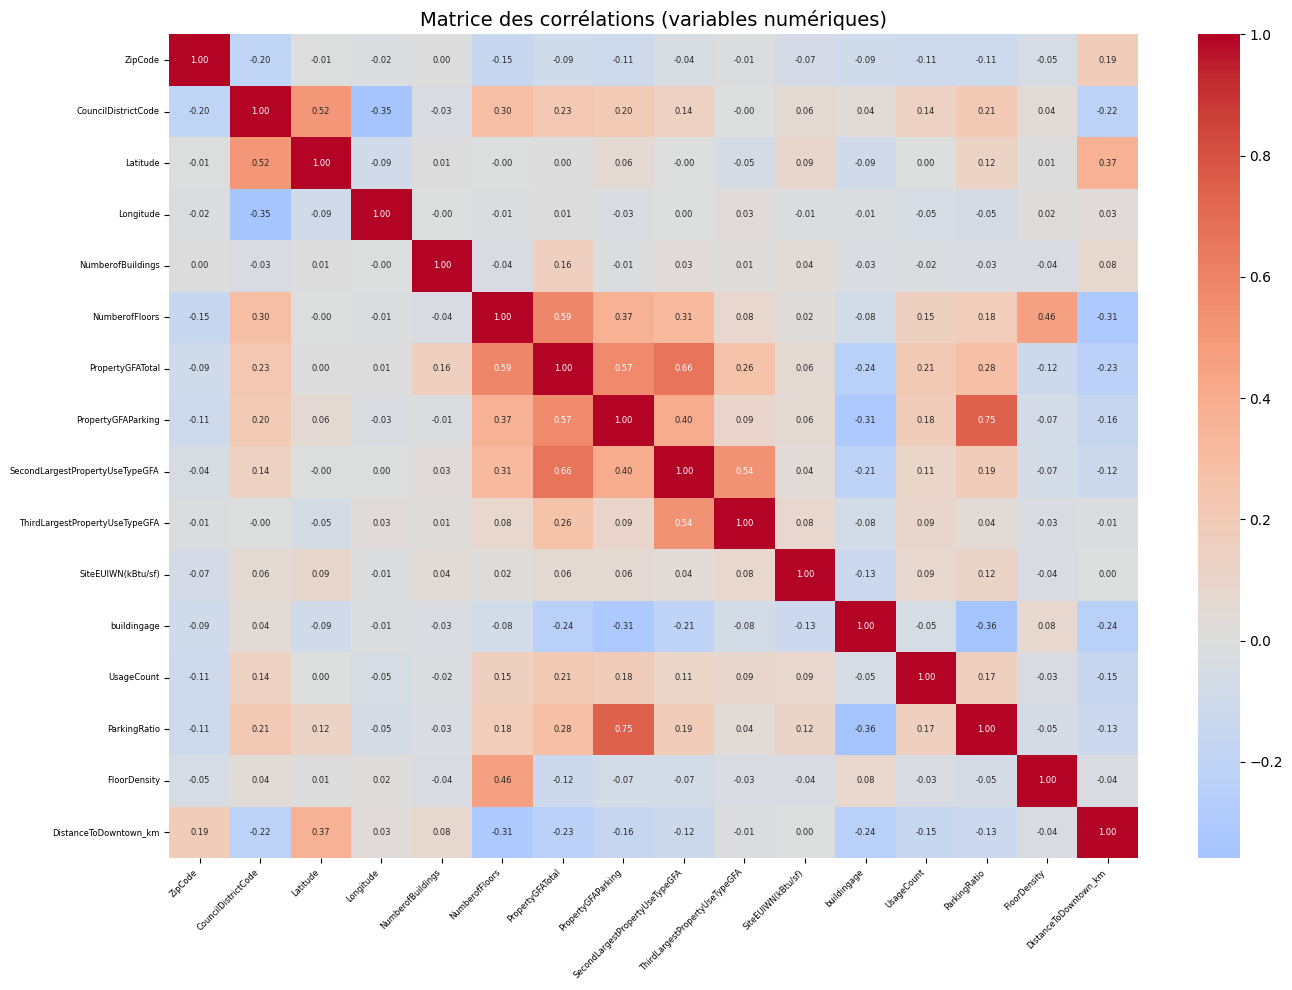

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sélection des variables numériques
corr = df_model.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 6}
)

plt.title("Matrice des corrélations (variables numériques)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()
